# Preprocessing

In [104]:
# creating dataset by cropping annotations from images
import yaml
import os
import random
from PIL import Image
from tqdm import tqdm
from xml.etree import ElementTree as ET
import pandas as pd

def get_class(label):
    config = get_config()
    lookup = pd.read_csv(config['path']['packet_lookup'])
    lookup = lookup.dropna()
    try:
        label = lookup.loc[lookup['label_annotation_file']==label, 'display_label'].values[0]
    except:
        label = None
    
    return label

def get_config(file = "cpu_config"):
    """
    Get the config from the specified config file.
    
    Parameters:
    file (str): Name of the config file
    
    Returns:
    obj: yaml object    
    """

    # project_path = ""
    # config_path = os.path.join(project_path, 
    #                             "config/" + file + ".yaml")

    config_path = 'crop.yaml'
    with open(config_path) as file:
        config = yaml.full_load(file)
        
    return config 

def read_annotation(file, exclude=[], use_lookup=True):
    
    tree = ET.parse(file)
    root_element = tree.getroot()
    image = root_element.find('filename').text
    bbox = []
    
    for obj in root_element.findall('object'):
        name = obj.find('name').text
        if name in exclude:
            continue
        if use_lookup:
            name = get_class(name)
            if name is None:
                continue
        for boxes in obj.findall('bndbox'):
            left = int(boxes.find('xmin').text)
            top = int(boxes.find('ymin').text)
            right = int(boxes.find('xmax').text)
            bottom = int(boxes.find('ymax').text)
            box = {"class": name,
                   "xmin": left,
                   "ymin": top,
                   "xmax": right,
                   "ymax": bottom}
            bbox.append(box)
            
    return image, bbox
    
class PrepareCropImages:
    
    def __init__(self):
        self.config = get_config("similarity_config")
        self.data_folder = self.config['image_crop']['data_folder']
        self.all_images_path = self.config['image_crop']['all_images_path']
        self.all_annotations_path = self.config['image_crop']['all_annotations_path']
        self.cropped_images_path = self.config['image_crop']['cropped_images_path']
        self.threshold = self.config['image_crop']['threshold']
        self.image_size = self.config['image_crop']['image_size']
        self.valid_size = self.config['image_crop']['valid_size']
        
        self.all_annotations = os.listdir(self.data_folder + self.all_annotations_path)
        random.shuffle(self.all_annotations)
        
        self.all_images = os.listdir(self.data_folder + self.all_images_path)
        random.shuffle(self.all_images)
        
        n_training = int(len(self.all_annotations) * (1-self.valid_size))
        
        self.training_annotations = self.all_annotations[0:n_training]
        self.validation_annotations = self.all_annotations[n_training:]
        
        self.image_label_dict_train = {}
        self.image_label_dict_valid = {}
        self.labels_crossed_threshold = []
       
    
    def crop_images(self):
        for image_name in tqdm(self.all_images):
            image_path = self.data_folder + self.all_images_path + image_name
            
            # annotation file and path
            annotation_name = '.'.join(image_name.split('.')[:-1]) + '.xml'
            if annotation_name not in self.all_annotations:
                continue
            
            annotation_path = self.data_folder + self.all_annotations_path + annotation_name
            
            # annotation
            image_annotation = read_annotation(annotation_path, use_lookup= True)
            
            image = Image.open(image_path)
            for i in image_annotation[1]:
                label = i['class']
                
                # threshold to be applied only on training dataset
                if annotation_name in self.training_annotations:
                    if label in self.labels_crossed_threshold:
                        continue
                    
                image_cropped = image.crop((i['xmin'], i['ymin'], i['xmax'], i['ymax']))
                
                if self.image_size:
                    image_cropped = image_cropped.resize(size= (self.image_size, self.image_size))
        
                if annotation_name in self.training_annotations:
                    if label in self.image_label_dict_train.keys():
                        self.image_label_dict_train[label].append(image_cropped)
                        
                        if self.threshold:
                            if len(self.image_label_dict_train[label]) >= self.threshold:
                                self.labels_crossed_threshold.append(label)
                    else:
                        self.image_label_dict_train[label] = [image_cropped]
                
                elif annotation_name in self.validation_annotations:
                    if label in self.image_label_dict_valid.keys():
                        self.image_label_dict_valid[label].append(image_cropped)
                    else:
                        self.image_label_dict_valid[label] = [image_cropped]
                else:
                    print('Annotation missing in both train and validation')
        
    
    def save_images(self, label_dict, sub_folder):

        from datetime import date
        today = date.today()
        date = today.strftime("%m%d")

        self.save_to_path = f"{self.data_folder}{self.cropped_images_path}{date}_{self.threshold}threshold_{self.image_size}image_size_{len(self.image_label_dict_train.keys())}folders"

        try:
            os.mkdir(self.save_to_path)
        except:
            pass

        self.save_to_path = f"{self.save_to_path}/{sub_folder}"

        try:
            os.mkdir(self.save_to_path)
        except:
            pass


        for i in label_dict.keys():
            try:
                curr_folder = self.save_to_path + "/" + i
                os.mkdir(curr_folder)
            except:
                pass

            for c, image in enumerate(label_dict[i]):
                image_name = 'Image ' + str(c+1)
                try:
                    image.save(f"{curr_folder}/{image_name}.jpg")
                except:
                    print('Issue with image')
                    
        if sub_folder == 'valid':
            for i in self.image_label_dict_train.keys():
                if i not in self.image_label_dict_valid.keys():
                    try:
                        curr_folder = self.save_to_path + "/" + i
                        os.mkdir(curr_folder)
                        print('Created dummy folder' + curr_folder)
                    except:
                        pass
                    
                
    def crop_and_save(self):
        self.crop_images()
        
        self.save_images(self.image_label_dict_train, 'train')
        self.save_images(self.image_label_dict_valid, 'valid')

In [105]:
crop_obj = PrepareCropImages()
crop_obj.crop_and_save()


100%|██████████| 1627/1627 [00:45<00:00, 35.65it/s]


Created dummy folder/home/sumit-tyagi/sumit-ssd/sumit/data//cropped_images/1021_0threshold_0image_size_45folders/valid/saladitas_clasica_caja
Created dummy folder/home/sumit-tyagi/sumit-ssd/sumit/data//cropped_images/1021_0threshold_0image_size_45folders/valid/mini_mamut_caddie
Created dummy folder/home/sumit-tyagi/sumit-ssd/sumit/data//cropped_images/1021_0threshold_0image_size_45folders/valid/Strip
Created dummy folder/home/sumit-tyagi/sumit-ssd/sumit/data//cropped_images/1021_0threshold_0image_size_45folders/valid/Other
Created dummy folder/home/sumit-tyagi/sumit-ssd/sumit/data//cropped_images/1021_0threshold_0image_size_45folders/valid/pancrema_clasica_paquetin


# Classification

In [2]:
# ! pip install tensorflow
# ! pip install tensorflow-gpu
# ! pip install tensorflow_hub
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install scipy
# ! pip install scikit-learn
# ! sudo apt-get install python-scipy

from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    print("Libraries Installed!")

Libraries Installed!


In [106]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
#from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
train_path = '/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/train' 
validation_path = '/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/valid'
test_path = '/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/valid'

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
classes = ['mamut_clasico_paquetin', 'bizcochitos_clasica_bolsa',
       'delicias_bolsa', 'ricanelas_paquetin',
       'florentinas_cajeta_paquetin', 'florentinas_fresa_paquetin',
       'marias_doradas', 'chokis_clasico_rollo', 'emperador_piruetas',
       'emperador_chocolate', 'cremas_de_nieve_surtido_caddie',
       'cremax_de_nieve_fresa', 'senzo_mix_paquetin',
       'giro_chocolate_paquetin', 'emperador_nuez', 'emperador_nocturno',
       'emperador_vainilla_paquetin', 'emperador_combinado',
       'chokis_brownie_paquetin', 'arcoiris_fruts_paquetin',
       'chokis_chokomax_paquetin', 'choko_chokis_paquetin',
       'cremax_de_nieve_vainilla', 'cremax_de_nieve_chocolate',
       'crackets_regular_rollo', 'saladitas_clasica_paquetin',
       'marias_clasica_rollo', 'marias_azucaradas_rollo', 'Rack Row',
       'Complete Rack', 'Strip', 'maravillas', 'flor_de_naranjo_paquetin',
       'chokis_chocotella_paquetin', 'arcoiris_clasico_paquetin',
       'bombitos_clasica_bolsa', 'habaneras_integrales_rollo', 'Other',
       'chocolatines_paquetin', 'minichokis_bolsa', 'mini_mamut_caddie',
       'mini_marias_bolsa', 'flipy_caddie', 'barras_de_coco_paquetin',
       'OtherItem']
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = classes, batch_size = 10)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = classes, batch_size = 5)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = classes, batch_size = 5)

Found 2574 images belonging to 45 classes.
Found 674 images belonging to 45 classes.
Found 674 images belonging to 45 classes.


In [11]:
len(classes)
# set(classes) - set([x.split("/")[-1] for x in [x[0] for x in os.walk('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/train')][1:]])
set([x.split("/")[-1] for x in [x[0] for x in os.walk('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/valid')][1:]]) - set([x.split("/")[-1] for x in [x[0] for x in os.walk('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/train')][1:]])

set()

In [8]:
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (10, 224, 224, 3)
labels batch shape: (10, 45)


Package: arcoiris_clasico_paquetin


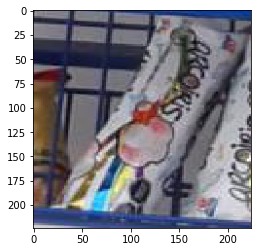

In [13]:
img_path = r'/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1020_0threshold_0image_size_45folders/train/arcoiris_clasico_paquetin/Image 1.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)

print("Package: arcoiris_clasico_paquetin")

In [34]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
inception_resnet_model = InceptionResNetV2(weights = 'imagenet')

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
inception_resnet_model.summary()

In [107]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import pickle


class ClassificationModel:
    '''Train the classification model using Pre-Trained models'''
    
    def __init__(self):
        
        self.config = get_config("similarity_config")
        
        # input data
        self.input_data_directory = self.config['classification_model_training']['input_data_directory']
        self.test_directory = self.config['classification_model_training']['test_directory']
        
        # image processing
        self.image_size = self.config['classification_model_training']['image_size']
        self.width_shift_range = self.config['classification_model_training']['width_shift_range']
        self.height_shift_range = self.config['classification_model_training']['height_shift_range']
        self.shear_range = self.config['classification_model_training']['shear_range']
        self.zoom_range = self.config['classification_model_training']['zoom_range']
        
        # model architecture
        self.pretrained_base = self.config['classification_model_training']['pretrained_base']
        self.train_layers = self.config['classification_model_training']['train_layers']
        self.train_batchnormalization = self.config['classification_model_training']['train_batchnormalization']
        self.stack_layers = self.config['classification_model_training']['stack_layers']
        self.n_classes = self.config['classification_model_training']['n_classes']
        
        # model training
        self.learning_rate = self.config['classification_model_training']['learning_rate']      
        self.loss = self.config['classification_model_training']['loss']
        self.epochs = self.config['classification_model_training']['epochs']
        self.class_weight_lower = self.config['classification_model_training']['class_weight_lower']
        self.class_weight_upper = self.config['classification_model_training']['class_weight_upper']
        self.batch_size = self.config['classification_model_training']['batch_size']
        self.use_callback_red_learning_rate = self.config['classification_model_training']['use_callback_red_learning_rate']
        self.use_callback_early_stopping = self.config['classification_model_training']['use_callback_early_stopping']
        
        # model save path
        self.save_base_dir = self.config['classification_model_training']['save_base_dir']
        
        self.train_directory = self.input_data_directory + 'train/'
        self.valid_directory = self.input_data_directory + 'valid/'
        
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
        self.early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        self.callbacks = []
        
        if self.use_callback_red_learning_rate:
            self.callbacks.append(self.reduce_lr)
            
        if self.use_callback_early_stopping:
            self.callbacks.append(self.early_stopping)
            
        self.data_generators()
        self.calculate_class_weights()
        self.load_model()
            
        
        from datetime import date
        today = date.today()
        date = today.strftime("%m%d")
        
        self.model_name = f'{date}_{self.pretrained_base}_{self.learning_rate}LR_{self.epochs}Epoch_{self.n_classes}Classes/'
        
        self.model_save_path = self.save_base_dir + self.model_name
        
        try:
            os.mkdir(self.model_save_path)
        except:
            pass
        
        # save data dictionary
        model_params = open(self.model_save_path + "model_params.txt","w")
        for key, value in self.config['classification_model_training'].items():
            model_params.write(str(key) + " : " + str(value) + "\n")
        model_params.close()
            
    def data_generators(self):
        '''Creates the data generators to load train/valid/test images'''
        
        self.train_datagen = ImageDataGenerator(
                rescale=1/255.,
                width_shift_range=self.width_shift_range,
                height_shift_range=self.height_shift_range,
                shear_range=self.shear_range,
                zoom_range=self.zoom_range,
                fill_mode='nearest')

        self.valid_datagen = ImageDataGenerator(
                rescale=1/255.,
                fill_mode='nearest')
        
        self.test_datagen = ImageDataGenerator(
                rescale=1/255.,
                fill_mode='nearest')
        
        self.train_generator = self.train_datagen.flow_from_directory(
                self.train_directory,
                target_size=(self.image_size,self.image_size),
                batch_size=self.batch_size)
        
        self.valid_generator = self.valid_datagen.flow_from_directory(
                self.valid_directory,
                target_size=(self.image_size,self.image_size),
                batch_size=self.batch_size)
        
        # sanity checks
        assert self.train_generator.class_indices == self.valid_generator.class_indices, "Mismatch in train validation indices"
        assert len(self.train_generator.class_indices) == self.n_classes, "Mismatch in no. of classes"
        
        
    def calculate_class_weights(self):
        self.training_distribution = {}
        total_training_bbox = 0
        
        for i in self.train_generator.filenames:
            total_training_bbox += 1
            sub_brand = i.split("/")[0]
            if sub_brand in self.training_distribution.keys():
                self.training_distribution[sub_brand] += 1
            else:
                self.training_distribution[sub_brand] = 1
        
        self.class_weight_dict = {}
        for key, value in self.training_distribution.items():
            self.class_weight_dict[self.train_generator.class_indices[key]] = np.clip(1/(100 * value/total_training_bbox),
                                  self.class_weight_lower, self.class_weight_upper)
            
            
    def load_model(self):
        if self.pretrained_base == 'VGG16':
            self.conv_base = VGG16(weights='imagenet',
                                   include_top=False,
                                   input_shape=(self.image_size,self.image_size,3))
            
        elif self.pretrained_base == 'InceptionResNetV2':
            self.conv_base = InceptionResNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(self.image_size,self.image_size,3))
            
        elif self.pretrained_base == 'ResNet50':
            self.conv_base = ResNet50(weights='imagenet',
                                               include_top=False,
                                               input_shape=(self.image_size,self.image_size,3))
        
        else:
            assert False, 'Model not added'
            
        
        # freezing the layers
        self.conv_base.trainable = True
    
        set_trainable = False
        for layer in self.conv_base.layers:
            
            if layer.name in self.train_layers:
                set_trainable = True
                
            if self.train_batchnormalization:
                if "BatchNormalization" in layer.__class__.__name__:
                    set_trainable = True
            
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        
        self.model = models.Sequential()
        self.model.add(self.conv_base)
        self.model.add(layers.Flatten())
        
        for i in self.stack_layers:
            self.model.add(layers.Dense(i, activation='relu'))
            
        self.model.add(layers.Dense(self.n_classes, activation='softmax'))
        
        print(self.model.summary())
        
        
        self.model.compile(loss=self.loss,
                      optimizer=optimizers.RMSprop(lr=self.learning_rate),
                      metrics=['acc'])
        
        
    def train_model(self):
        self.history = self.model.fit(
                self.train_generator,
                steps_per_epoch=self.train_generator.samples//self.batch_size,
                epochs=self.epochs,
                validation_data=self.valid_generator,
                validation_steps=self.valid_generator.samples//self.batch_size,
                callbacks=self.callbacks)

        print('Training complete')

        self.model.save(self.model_save_path + 'model.h5')
        with open(self.model_save_path + 'class_indices.pickle', 'wb') as handle:
            pickle.dump(self.train_generator.class_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

                
    def create_evaluation_metrics(self, image_files, base_dir, class_indices_dict):
        '''Returns the evaulation table with precision, recall & f1-Score
        Params:
            image_files (list): images with naming convention to include sub-brand label
            base_dir (string): directory having images in structure sub_brand --> images
        '''
        
        # dictionary to include metrics of all the classes
        final_dict = {}
    
        for i in tqdm(image_files):
            i = base_dir + i
            
            # to be replaced with keras data generator to make batch predictions
            image = Image.open(i)
            
            image = image.resize(size= (self.image_size, self.image_size))
            image = np.array(image)/255.0
            image = image.reshape(1,self.image_size,self.image_size,3)
    
            actual_label = i.split("/")[-2]
            pred_label = class_indices_dict[np.argmax(self.model.predict(image))]
    
            # initializing dict for each sub-brand
            if actual_label not in final_dict.keys():
                final_dict[actual_label] = {'Total Positive': 0, 'TP': 0, 'FP': 0, 'FN': 0}
    
            if pred_label not in final_dict.keys():
                final_dict[pred_label] = {'Total Positive': 0, 'TP': 0, 'FP': 0, 'FN': 0}
    
            # increment the values
            final_dict[actual_label]['Total Positive'] += 1
    
            if actual_label == pred_label:
                final_dict[actual_label]['TP'] += 1
            else:
                final_dict[pred_label]['FP'] += 1
                final_dict[actual_label]['FN'] += 1
                
                
        df_results = pd.DataFrame(columns = ['Sub-Brand', 'Total Positives', 'TP', 'FP', 'FN'])
    
        for key, value in final_dict.items():
            row = [key, value['Total Positive'], value ['TP'], value['FP'], value['FN']]
            a_series = pd.Series(row, index = df_results.columns)
            df_results = df_results.append(a_series, ignore_index=True)
        
        # calculation of precision & recall
        r_num = np.where(df_results['Total Positives'] == 0, 0, 100 * df_results['TP'])
        r_denom = np.where(df_results['Total Positives'] == 0, 1, df_results['Total Positives'])
        df_results['Recall'] =  r_num/r_denom
    
        p_denom = np.where(df_results['TP'] + df_results['FP'] == 0, 1, df_results['TP'] + df_results['FP'])
        df_results['Precision'] = 100 * df_results['TP']/p_denom
        
        p = df_results['Precision']
        r = df_results['Recall']
        df_results['F1-Score'] = (2 * p * r)/np.where((p + r) == 0, 1, (p + r))
         
        return df_results
    
    def evaluate_model(self):
        class_indices_dict = {value:key for key,value in self.train_generator.class_indices.items()}
        
        # validation metrics
        validation_df = self.create_evaluation_metrics(self.valid_generator.filenames, 
                                                       base_dir=self.valid_directory, 
                                                       class_indices_dict=class_indices_dict)
        
        # testing metrics
        all_sub_brands = os.listdir(self.test_directory)

        all_files = []
        for sub_brand in all_sub_brands:
            for image in os.listdir(self.test_directory + sub_brand):
                all_files.append(sub_brand + "/" + image)
                
        testing_df = self.create_evaluation_metrics(all_files,
                                                    base_dir=self.test_directory,
                                                    class_indices_dict=class_indices_dict)
        
        validation_df.to_csv(self.model_save_path + 'validation.csv', index= False)
        testing_df.to_csv(self.model_save_path + 'testing.csv', index= False)
        

    def cross_category_evaluation(self):  

        class_indices_dict = {value:key for key,value in self.train_generator.class_indices.items()}
        test_sub_brands = [v for v in class_indices_dict.values() if v in os.listdir(self.test_directory)]
                           
        df_cross_eval = pd.DataFrame(index= test_sub_brands, columns= test_sub_brands)
        df_cross_eval = df_cross_eval.fillna(0)
        # df_cross_eval.loc['Cheetos||Bolitas', 'Cheetos||Bolitas'] = 10
        
        from tensorflow.keras.preprocessing import image

        for value in tqdm(test_sub_brands):
            sub_brand_folder = self.test_directory + value + "/"
        
            # load all images into a list
            images = []
            for img in os.listdir(sub_brand_folder):
                img = os.path.join(sub_brand_folder, img)
                img = image.load_img(img, target_size=(self.image_size, self.image_size))
                img = image.img_to_array(img)
                img = img/255.0
                img = np.expand_dims(img, axis=0)
                images.append(img)
        
            images = np.vstack(images)
            classes = self.model.predict_classes(images, batch_size=10)
            classes = [class_indices_dict[i] for i in classes]
            for i in classes:
                df_cross_eval.loc[value, i] += 1
                
        row_sum = df_cross_eval.sum(axis= 1)
        for col in df_cross_eval.columns:
            df_cross_eval[col] = df_cross_eval[col]/row_sum
            
        df_cross_eval.to_csv(self.model_save_path + 'cross_category_evaluation_test.csv')
                                
        
    def train_and_evaluate(self):
        self.train_model()
        self.evaluate_model()
        self.cross_category_evaluation()

In [108]:
modelling_obj = ClassificationModel()

Found 4990 images belonging to 45 classes.
Found 783 images belonging to 45 classes.
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten_5 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               1573120   
_________________________________________________________________
dense_16 (Dense)             (None, 45)                11565     
Total params: 55,921,421
Trainable params: 55,860,013
Non-trainable params: 61,408
_________________________________________________________________
None


In [109]:
modelling_obj.train_and_evaluate()

Epoch 1/20
38/38 [==============================] - 51s 592ms/step - loss: 2.7743 - acc: 0.3142 - val_loss: 1.6696 - val_acc: 0.5951
Epoch 2/20
38/38 [==============================] - 21s 541ms/step - loss: 0.7078 - acc: 0.8181 - val_loss: 1.1717 - val_acc: 0.7565
Epoch 3/20
38/38 [==============================] - 20s 512ms/step - loss: 0.3830 - acc: 0.8925 - val_loss: 1.2948 - val_acc: 0.7734
Epoch 4/20
38/38 [==============================] - 20s 513ms/step - loss: 0.2557 - acc: 0.9249 - val_loss: 1.4902 - val_acc: 0.7982
Epoch 5/20
38/38 [==============================] - 20s 510ms/step - loss: 0.2254 - acc: 0.9352 - val_loss: 2.2736 - val_acc: 0.7956

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 6/20
38/38 [==============================] - 20s 511ms/step - loss: 0.1560 - acc: 0.9559 - val_loss: 1.4287 - val_acc: 0.8737
Epoch 7/20
38/38 [==============================] - 20s 512ms/step - loss: 0.1000 - acc: 0.9700 - val_loss: 1.5674 - val

  0%|          | 0/45 [00:00<?, ?it/s]/home/sumit-tyagi/sumit-ssd/common-biscuit/installs/anaconda3/envs/classify/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
  2%|▏         | 1/45 [00:00<00:03, 13.61it/s]


ValueError: need at least one array to concatenate

In [110]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import math
from IPython.display import display

import tensorflow as tf

from tensorflow.keras.applications import VGG16, ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers


In [150]:
model_name = '1021_InceptionResNetV2_0.0002LR_15Epoch_45Classes'
save_base_dir = '/tf/common/blob_data/data/models/sub_brands_keras_pretrained/'

In [151]:
model = models.load_model('/home/sumit-tyagi/sumit-ssd/sumit/data/model_files/sub_brand_classification/1021_InceptionResNetV2_0.0002LR_15Epoch_45Classes/model.h5')

In [153]:
with open('/home/sumit-tyagi/sumit-ssd/sumit/data/model_files/sub_brand_classification/1021_InceptionResNetV2_0.0002LR_15Epoch_45Classes/class_indices.pickle', 'rb') as handle:
    class_indices_dict = pickle.load(handle)
class_indices_dict = {value:key for key,value in class_indices_dict.items()}

In [156]:
from tensorflow.keras.preprocessing import image

img_width, img_height = 128, 128
img = image.load_img(r'/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/valid/arcoiris_clasico_paquetin/Image 1.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print(class_indices_dict[classes[0]])

crackets_regular_rollo


Text(0.5, 1.0, 'maravillas/ maravillas')

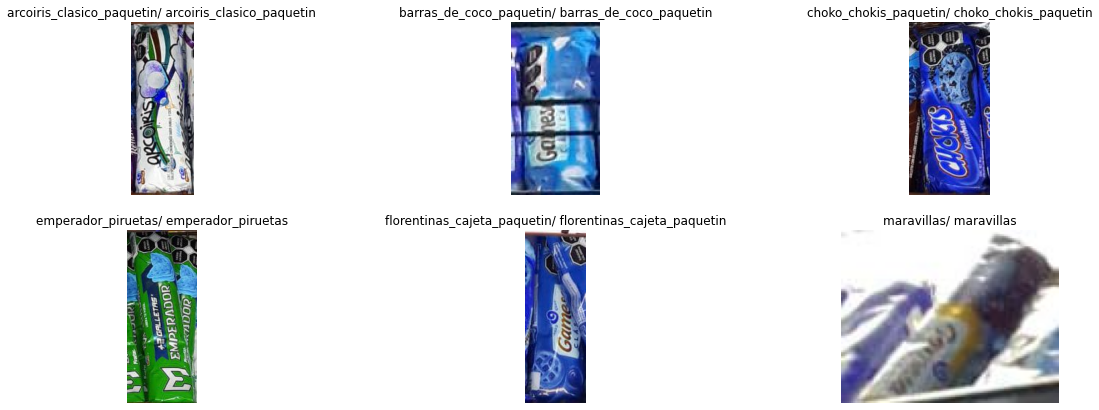

In [163]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(20, 7))

# setting values to rows and column variables
rows = 2
columns = 3

# reading images
Image1 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/arcoiris_clasico_paquetin/Image 1.jpg')
Image2 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/barras_de_coco_paquetin/Image 1.jpg')
Image3 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/choko_chokis_paquetin/Image 1.jpg')
Image4 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/emperador_piruetas/Image 1.jpg')
Image5 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/florentinas_cajeta_paquetin/Image 1.jpg')
Image6 = cv2.imread('/home/sumit-tyagi/sumit-ssd/sumit/data/cropped_images/1021_0threshold_0image_size_45folders/train/maravillas/Image 3.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("arcoiris_clasico_paquetin/ arcoiris_clasico_paquetin")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("barras_de_coco_paquetin/ barras_de_coco_paquetin")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("choko_chokis_paquetin/ choko_chokis_paquetin")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("emperador_piruetas/ emperador_piruetas")


# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("florentinas_cajeta_paquetin/ florentinas_cajeta_paquetin")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("maravillas/ maravillas")


In [ ]:
!pip install opencv-python